# TP1 - SPARK-Bikeshare
## - Lamara MOUZNI - Aghilas SMAIL

In [0]:
csv_file = "/FileStore/tables/202002_baywheels_tripdata.csv"

# Create database and managed tables
spark.sql("DROP DATABASE IF EXISTS bike_share_db CASCADE") 
spark.sql("CREATE DATABASE bike_share_db")
spark.sql("USE bike_share_db")

DataFrame[]

In [0]:
df = (spark
      .read
	 .format("csv")
	 .option("header", "true")
	 .option("mode", "FAILFAST")  # exit if any errors
	 .option("nullValue", "")	  # replace any null data field with “”
  	 .option("inferSchema", "true")
	 .option("path", csv_file)
	 .load())

In [0]:
%sql
DROP TABLE IF EXISTS 202002_baywheels_tripdata;

In [0]:
df.write.mode("overwrite").saveAsTable("202002_baywheels_tripdata")

In [0]:
%sql
CACHE TABLE 202002_baywheels_tripdata

## Scénario  1 : La différence entre le nombre de vélos entrant et sortant pour chaque station :

In [0]:
count_trips_start = spark.sql("SELECT start_station_id as station_id, start_station_name as station_name, start_station_latitude as latitude, start_station_longitude as longitude, count(*) as nb_trips_start FROM 202002_baywheels_tripdata GROUP BY start_station_id, start_station_name, start_station_latitude, start_station_longitude ORDER BY station_id;")

count_trips_end = spark.sql("SELECT end_station_id as station_id, end_station_name as station_name, end_station_latitude as latitude, end_station_longitude as longitude, count(*) as nb_trips_end FROM 202002_baywheels_tripdata GROUP BY end_station_id, end_station_name, end_station_latitude, end_station_longitude ORDER BY station_id;")

count_trips = count_trips_start.join(count_trips_end, (count_trips_start.station_id == count_trips_end.station_id) & (count_trips_start.station_name == count_trips_end.station_name), 
                     "inner") \
              .select(count_trips_start.station_id, 
                      count_trips_start.station_name,  
                      count_trips_start.latitude,
                      count_trips_start.longitude,
                      count_trips_start.nb_trips_start,
                      count_trips_end.nb_trips_end).orderBy("station_id")
count_trips.show(5)

+----------+--------------------+-------------+---------------+--------------+------------+
|station_id|        station_name|     latitude|      longitude|nb_trips_start|nb_trips_end|
+----------+--------------------+-------------+---------------+--------------+------------+
|         3|Powell St BART St...|37.7863752686|-122.4049043655|          1872|        2143|
|         4|Cyril Magnin St a...|37.7858806269|-122.4089150084|           300|         314|
|         5|Powell St BART St...|37.7838993571|-122.4084448814|          1878|        1901|
|         6|The Embarcadero a...|     37.80477|    -122.403234|           871|        1052|
|         7| Frank H Ogawa Plaza|37.8045623549|-122.2717380524|           631|         659|
+----------+--------------------+-------------+---------------+--------------+------------+
only showing top 5 rows



In [0]:
!pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 2.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [0]:
import folium
from IPython.display import display

# Créez une carte géographique centrée sur une position GPS initiale
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)  # Coordonnées GPS de San Francisco

# Ajoutez des marqueurs pour chaque emplacement avec des informations personnalisées
for row in count_trips.collect():
    radius_s = row['nb_trips_start']/100 
    folium.CircleMarker([row['latitude'], row['longitude']], radius=radius_s, color='blue', fill=True, fill_color='blue',
                        popup=f"Station: {row['station_name']}<br>Nombre de trajets (départ): {row['nb_trips_start']}").add_to(m)

# Affichez la carte
display(m)

In [0]:
# Créez une carte géographique centrée sur une position GPS initiale
m1 = folium.Map(location=[37.7749, -122.4194], zoom_start=12)  # Coordonnées GPS de San Francisco

# Ajoutez des marqueurs pour chaque emplacement avec des informations personnalisées
for row in count_trips.collect():
    radius_e = row['nb_trips_end']/100 
    folium.CircleMarker([row['latitude'], row['longitude']], radius=radius_e, color='red', fill=True, fill_color='red',
                        popup=f"Station: {row['station_name']}<br>Nombre de trajets (arrivée): {row['nb_trips_end']}").add_to(m1)

# Affichez la carte
display(m1)

- Visualiser la différence entre le nombre de trajets partant et sortant pour chaque stations sur une carte.
En vert les stations ou le le nombre de trajets entrant et plus grand.
En vert les stations ou le le nombre de trajets sortant et plus grand.

In [0]:
# Créez une carte géographique centrée sur une position GPS initiale avec un zoom moins élevé
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Ajoutez des cercles pour chaque emplacement avec des tailles basées sur la différence entre value1 et value2
for row in count_trips.collect():
    diff = row['nb_trips_end'] - row['nb_trips_start']  # Calculez la différence
    radius = abs(diff)/50  # Utilisez la valeur absolue de la différence pour définir la taille du cercle

    # Définissez la couleur en fonction de la différence (rouge foncé pour négatif, vert pour positif)
    if diff < 0:
        color = "red"
    else:
        color = "green"
    
    folium.CircleMarker([row['latitude'], row['longitude']], radius=radius, color=color, fill=True, fill_color=color,
                        popup=f"Station: {row['station_name']}<br> Départs: {row['nb_trips_start']}<br>Arrivée: {row['nb_trips_end']}<br>Diff: {diff}").add_to(m)

# Affichez la carte dans le notebook
display(m)

## Scénario  2 : Nombre d'utilisateurs par heure

In [0]:
trips_hour_sub = spark.sql("SELECT hour(start_time) as hour, count(*) as nb_trips FROM 202002_baywheels_tripdata WHERE user_type = 'Subscriber' GROUP BY hour ORDER BY hour")
trips_hour_sub.show(24)
trips_hour_cus = spark.sql("SELECT hour(start_time) as hour, count(*) as nb_trips FROM 202002_baywheels_tripdata WHERE user_type = 'Customer' GROUP BY hour ORDER BY hour")
trips_hour_cus.show(24)

+----+--------+
|hour|nb_trips|
+----+--------+
|   0|    2081|
|   1|    1462|
|   2|    1051|
|   3|     548|
|   4|     536|
|   5|    1594|
|   6|    5630|
|   7|   15136|
|   8|   25420|
|   9|   18695|
|  10|   12187|
|  11|   13216|
|  12|   14565|
|  13|   14564|
|  14|   14675|
|  15|   16547|
|  16|   22943|
|  17|   30162|
|  18|   22595|
|  19|   15788|
|  20|   11171|
|  21|    8068|
|  22|    5444|
|  23|    3368|
+----+--------+

+----+--------+
|hour|nb_trips|
+----+--------+
|   0|     975|
|   1|     639|
|   2|     476|
|   3|     193|
|   4|     227|
|   5|     772|
|   6|    2551|
|   7|    7016|
|   8|   15347|
|   9|   12654|
|  10|    7647|
|  11|    7520|
|  12|    8345|
|  13|    8273|
|  14|    8240|
|  15|    8895|
|  16|   11589|
|  17|   17055|
|  18|   13250|
|  19|    8728|
|  20|    5769|
|  21|    4045|
|  22|    3005|
|  23|    1697|
+----+--------+



[2081, 1462, 1051, 548, 536, 1594, 5630, 15136, 25420, 18695, 12187, 13216, 14565, 14564, 14675, 16547, 22943, 30162, 22595, 15788, 11171, 8068, 5444, 3368]
[975, 639, 476, 193, 227, 772, 2551, 7016, 15347, 12654, 7647, 7520, 8345, 8273, 8240, 8895, 11589, 17055, 13250, 8728, 5769, 4045, 3005, 1697]


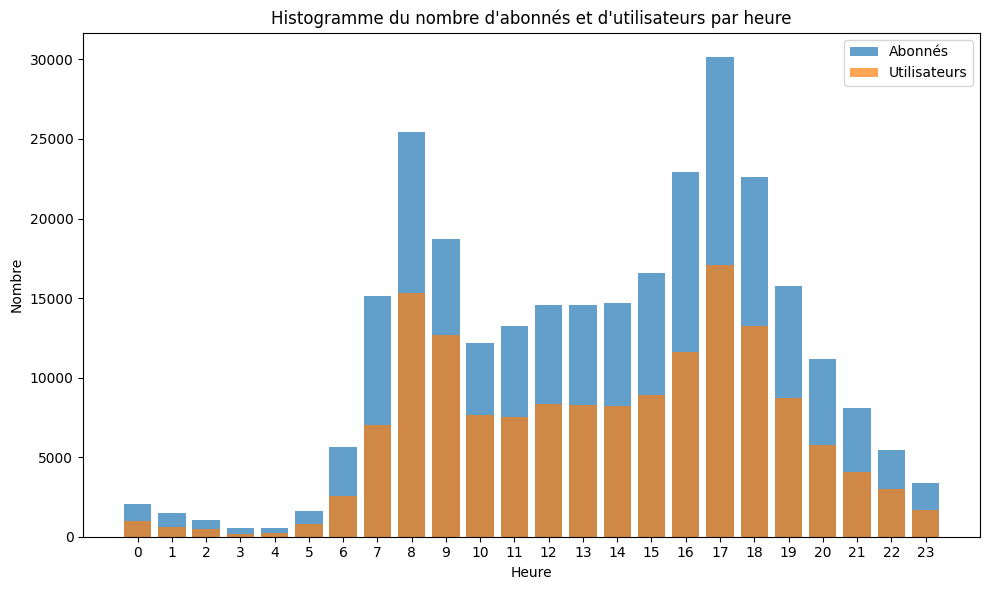

In [0]:
import matplotlib.pyplot as plt

hours = list(range(24))
nb_sub_hour = trips_hour_sub.select("nb_trips").rdd.flatMap(lambda x: x).collect()
nb_cus_hour = trips_hour_cus.select("nb_trips").rdd.flatMap(lambda x: x).collect()

# Créez un graphique d'histogramme
plt.figure(figsize=(10, 6))

# Tracez l'histogramme pour le nombre d'abonnés
plt.bar(hours, nb_sub_hour, label='Abonnés', alpha=0.7)

# Tracez l'histogramme pour le nombre d'utilisateurs
plt.bar(hours, nb_cus_hour, label='Utilisateurs', alpha=0.7)
print(nb_sub_hour)
print(nb_cus_hour)

# Ajoutez des étiquettes d'axe et un titre
plt.xlabel('Heure')
plt.ylabel('Nombre')
plt.title('Histogramme du nombre d\'abonnés et d\'utilisateurs par heure')

# Ajoutez une légende
plt.legend()

# Personnalisez d'autres paramètres si nécessaire
plt.xticks(hours)  # Assurez-vous que les heures sont affichées sur l'axe des x
plt.tight_layout()

# Affichez le graphique
plt.show()